In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt
import japanize_matplotlib
import math


In [2]:
# CSVファイルを読み込む
file_path = "./logs/terminal_coordinate/"

df_gyro = pd.read_csv(
    f"{file_path}Gyroscope.csv",
    header=0,
    names=("time", "x", "y", "z")
)

df_acc = pd.read_csv(
    f"{file_path}Accelerometer.csv",
    header=0,
    names=("time", "x", "y", "z")
)


In [3]:
# 加速度のノルムを計算する
df_acc['norm'] = np.linalg.norm(df_acc[['x', 'y', 'z']], axis=1)

# フィルターをかける
window = 40
## 移動平均
df_acc['xlow'] = df_acc['x'].rolling(window=window).mean()
df_acc['ylow'] = df_acc['y'].rolling(window=window).mean()
df_acc['zlow'] = df_acc['z'].rolling(window=window).mean()

## メディアンフィルター
df_acc['xmf'] = medfilt(df_acc['x'], window + 1)
df_acc['ymf'] = medfilt(df_acc['y'], window + 1)
df_acc['zmf'] = medfilt(df_acc['z'], window + 1)

## 移動平均
df_gyro['xlow'] = df_gyro['x'].rolling(window=window).mean()
df_gyro['ylow'] = df_gyro['y'].rolling(window=window).mean()
df_gyro['zlow'] = df_gyro['z'].rolling(window=window).mean()

## メディアンフィルター
df_gyro['xmf'] = medfilt(df_gyro['x'], window + 1)
df_gyro['ymf'] = medfilt(df_gyro['y'], window + 1)
df_gyro['zmf'] = medfilt(df_gyro['z'], window + 1)


In [4]:
# 角速度から角度を計算する
t = df_gyro['time'].max() - df_gyro['time'].min()
n = len(df_gyro)
a = np.degrees(t/n)

df_gyro['i_x'] = np.cumsum(df_gyro['x']) * a
df_gyro['i_y'] = np.cumsum(df_gyro['y']) * a
df_gyro['i_z'] = np.cumsum(df_gyro['z']) * a

df_gyro['i_xlow'] = np.cumsum(df_gyro['xlow']) * a
df_gyro['i_ylow'] = np.cumsum(df_gyro['ylow']) * a
df_gyro['i_zlow'] = np.cumsum(df_gyro['zlow']) * a

df_gyro['i_xmf'] = np.cumsum(df_gyro['xmf']) * a
df_gyro['i_ymf'] = np.cumsum(df_gyro['ymf']) * a
df_gyro['i_zmf'] = np.cumsum(df_gyro['zmf']) * a


In [5]:
# グラフを描画する
def plot(
    df,
    heads=[],
    title=None,
    xlabel=None,
    ylabel=None,
    figsize=(10, 3),
    xlim=(0, 0),
    ylim=(0, 0),
    grid=True,
):
    fig = plt.figure(figsize=figsize)

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if grid:
        plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)

    if xlim[0] < xlim[1]:
        plt.xlim(xlim[0], xlim[1])
    if ylim[0] < ylim[1]:
        plt.ylim(ylim[0], ylim[1])

    for head in heads:
        plt.plot(df[head[0]], df[head[1]], label=head[1])

    plt.legend()

    plt.show()


In [6]:
# 3次元グラフを描画する
def plot_arrow(
    points,
    xlim=(0, 0),
    ylim=(0, 0),
    zlim=(0, 0),
    figsize=(10, 10),
):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    if xlim[0] < xlim[1]:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim[0] < ylim[1]:
        ax.set_ylim(ylim[0], ylim[1])
    if zlim[0] < zlim[1]:
        ax.set_zlim(zlim[0], zlim[1])

    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    for i, point in enumerate(points):
        ax.quiver(
            0, 0, 0,
            point[0], point[1], point[2],
            arrow_length_ratio=0.1,
            color=colors[i % len(colors)],
        )

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()


In [7]:
def rotate(vec, roll, pitch, yaw):
    r_x = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    r_y = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    r_z = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])

    vec = np.dot(r_x, vec)
    vec = np.dot(r_y, vec)
    vec = np.dot(r_z, vec)

    return vec


In [8]:
def calculate_tilt(df):
    tilt_angles = []  # 傾きを格納するリスト

    # df を for で回す
    for d in df.itertuples(index=False):
        time = d.time
        x = d.x
        y = d.y
        z = d.z
        
        gravity = math.sqrt(x ** 2 + y ** 2 + z ** 2)

        # 重力方向となす角度を計算
        tilt_angle_x = math.acos(x / gravity)
        tilt_angle_y = math.acos(y / gravity)
        tilt_angle_z = math.acos(z / gravity)

        tilt_angles.append((time, tilt_angle_x, tilt_angle_y, tilt_angle_z))

    df_tilt = pd.DataFrame(tilt_angles, columns=["time", "roll", "pitch", "yaw"])
    return df_tilt


In [9]:
def get_nearest_time(df, target_time):
    # "time"列と目標時間との差分を計算
    df['time_diff'] = (df['time'] - target_time).abs()

    # 差分の絶対値が最小となる行を取得
    nearest_row = df.loc[df['time_diff'].idxmin()]

    # 最も近い時間の値を取得
    nearest_time = nearest_row['time']

    # "time_diff"列を削

    return nearest_time


In [17]:
# 端末座標系を端末の向きに合わせて回転させる
def rotate_device_coordinate_system(df):
    new_df = []
    for data in df.iterrows():
        roll = data[1]['roll'] - np.radians(90)
        pitch = data[1]['pitch']  - np.radians(90)
        yaw = data[1]['yaw']

        # 元のベクトル
        x = data[1]['x']
        y = data[1]['y']
        z = data[1]['z']

        vec = np.array([x, y, z])

        # 回転後のベクトル
        vec_dash = rotate(vec, yaw, roll, pitch)

        # 回転後の値を格納
        new_df.append([
            data[1]['time'],
            vec_dash[0],
            vec_dash[1],
            vec_dash[2],
        ])

    new_df = pd.DataFrame(new_df, columns=['time', 'x', 'y', 'z'])
    return new_df


In [11]:
df_tilt = calculate_tilt(df_acc)
tilts = []
for data in df_acc.iterrows():
    time = data[1]['time']
    nearest_time = get_nearest_time(df_tilt, time)

    # 傾きを取得
    tilt = df_tilt[df_tilt['time'] == nearest_time]
    tilts.append((tilt['roll'].values[0], tilt['pitch'].values[0], tilt['yaw'].values[0]))

tilts = np.array(tilts)

# df_acc に "roll", "pitch", "yaw" 列を追加
df_acc['roll'] = tilts[:, 0]
df_acc['pitch'] = tilts[:, 1]
df_acc['yaw'] = tilts[:, 2]


       time         x         y         z
0  0.018635  0.001888 -0.198206  9.725982
1  0.021016  0.001664 -0.184702  9.735729
2  0.023398  0.001381 -0.171662  9.721574
3  0.025780  0.001667 -0.184702  9.721369
4  0.028161  0.002035 -0.203181  9.721094


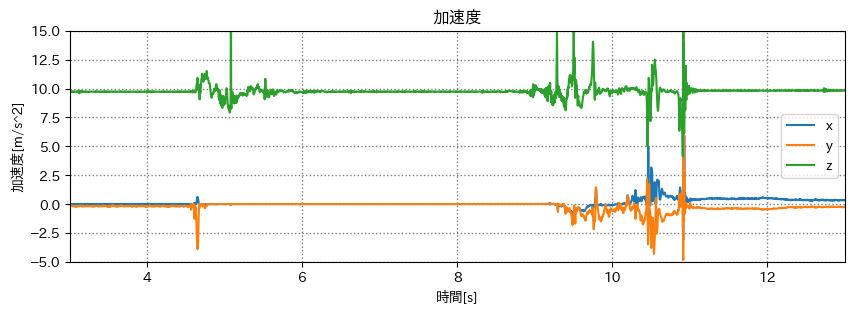

In [26]:
# rotate_device_coordinate_system
rotated_df_acc = rotate_device_coordinate_system(df_acc)
print(rotated_df_acc.head())

plot(
    rotated_df_acc,
    heads=[
        ('time', 'x'),
        ('time', 'y'),
        ('time', 'z'),
    ],
    title="加速度",
    xlabel="時間[s]",
    ylabel="加速度[m/s^2]",
    figsize=(10, 3),
    xlim=(3, 13),
    ylim=(-5, 15),
    grid=True
)


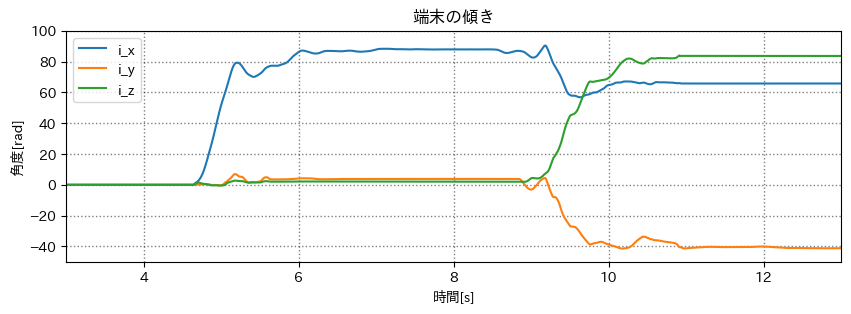

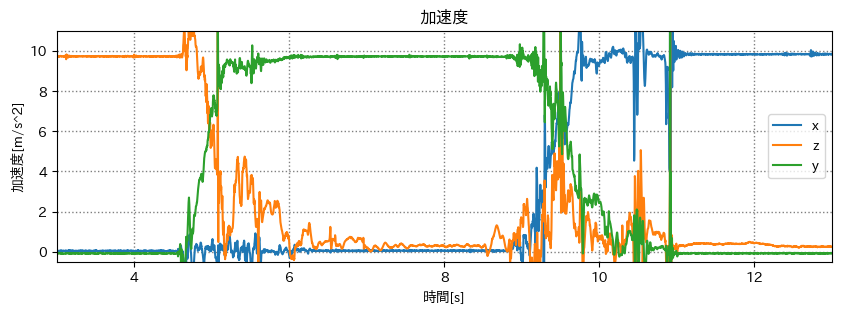

In [13]:
# 傾きのグラフ
plot(
    df_gyro,
    [("time", "i_x"), ("time", "i_y"), ("time", "i_z")],
    title="端末の傾き",
    xlabel="時間[s]",
    ylabel="角度[rad]",
    figsize=(10, 3),
    xlim=(3, 13),
    ylim=(-50, 100),
    grid=True
)

# 加速度のグラフ
plot(
    df_acc,
    [("time", "x"), ("time", "z"), ("time", "y")],
    title="加速度",
    xlabel="時間[s]",
    ylabel="加速度[m/s^2]",
    figsize=(10, 3),
    xlim=(3, 13),
    ylim=(-0.5, 11),
    grid=True
)


In [14]:
x = 0
y = 9.8
z = 0

gravity = math.sqrt(x ** 2 + y ** 2 + z ** 2)

roll = math.acos(x / gravity)
pitch = math.acos(y / gravity)
yaw = math.acos(z / gravity)

print(f'roll : {math.degrees(roll)}度')
print(f'pitch: {math.degrees(pitch)}度')
print(f'yaw  : {math.degrees(yaw)}度')


roll : 90.0度
pitch: 0.0度
yaw  : 90.0度
